In [4]:
# tools
import pandas as pd
import matplotlib.pyplot as plt
import plotly

# forecast
from statsforecast import StatsForecast
from utilsforecast.plotting import plot_series
from neuralforecast import NeuralForecast

# models
from neuralforecast.auto import AutoNHITS, AutoLSTM

# loss
from neuralforecast.losses.pytorch import MQLoss

# model tune
from ray import tune

import warnings
warnings.filterwarnings("ignore")

# data

In [3]:
def load_data():
    """
    data read and filter
    """
    # data read
    df = pd.read_parquet("https://datasets-nixtla.s3.amazonaws.com/m4-hourly.parquet")
    # data preprocessing
    # df["unique_id"] = df["unique_id"].astype("category")
    df['ds'] = df['ds'].astype('int')
    # data filter
    uids = df["unique_id"].unique()[:10]
    df = df.query("unique_id in @uids").reset_index(drop = True)
    
    return df


Y_df = load_data()
print(Y_df.head())
print()
print(Y_df.shape)
print()
print(Y_df["unique_id"].value_counts())

  unique_id  ds      y
0        H1   1  605.0
1        H1   2  586.0
2        H1   3  586.0
3        H1   4  559.0
4        H1   5  511.0

(7480, 3)

unique_id
H1      748
H10     748
H100    748
H101    748
H102    748
H103    748
H104    748
H105    748
H106    748
H107    748
Name: count, dtype: int64


# EDA

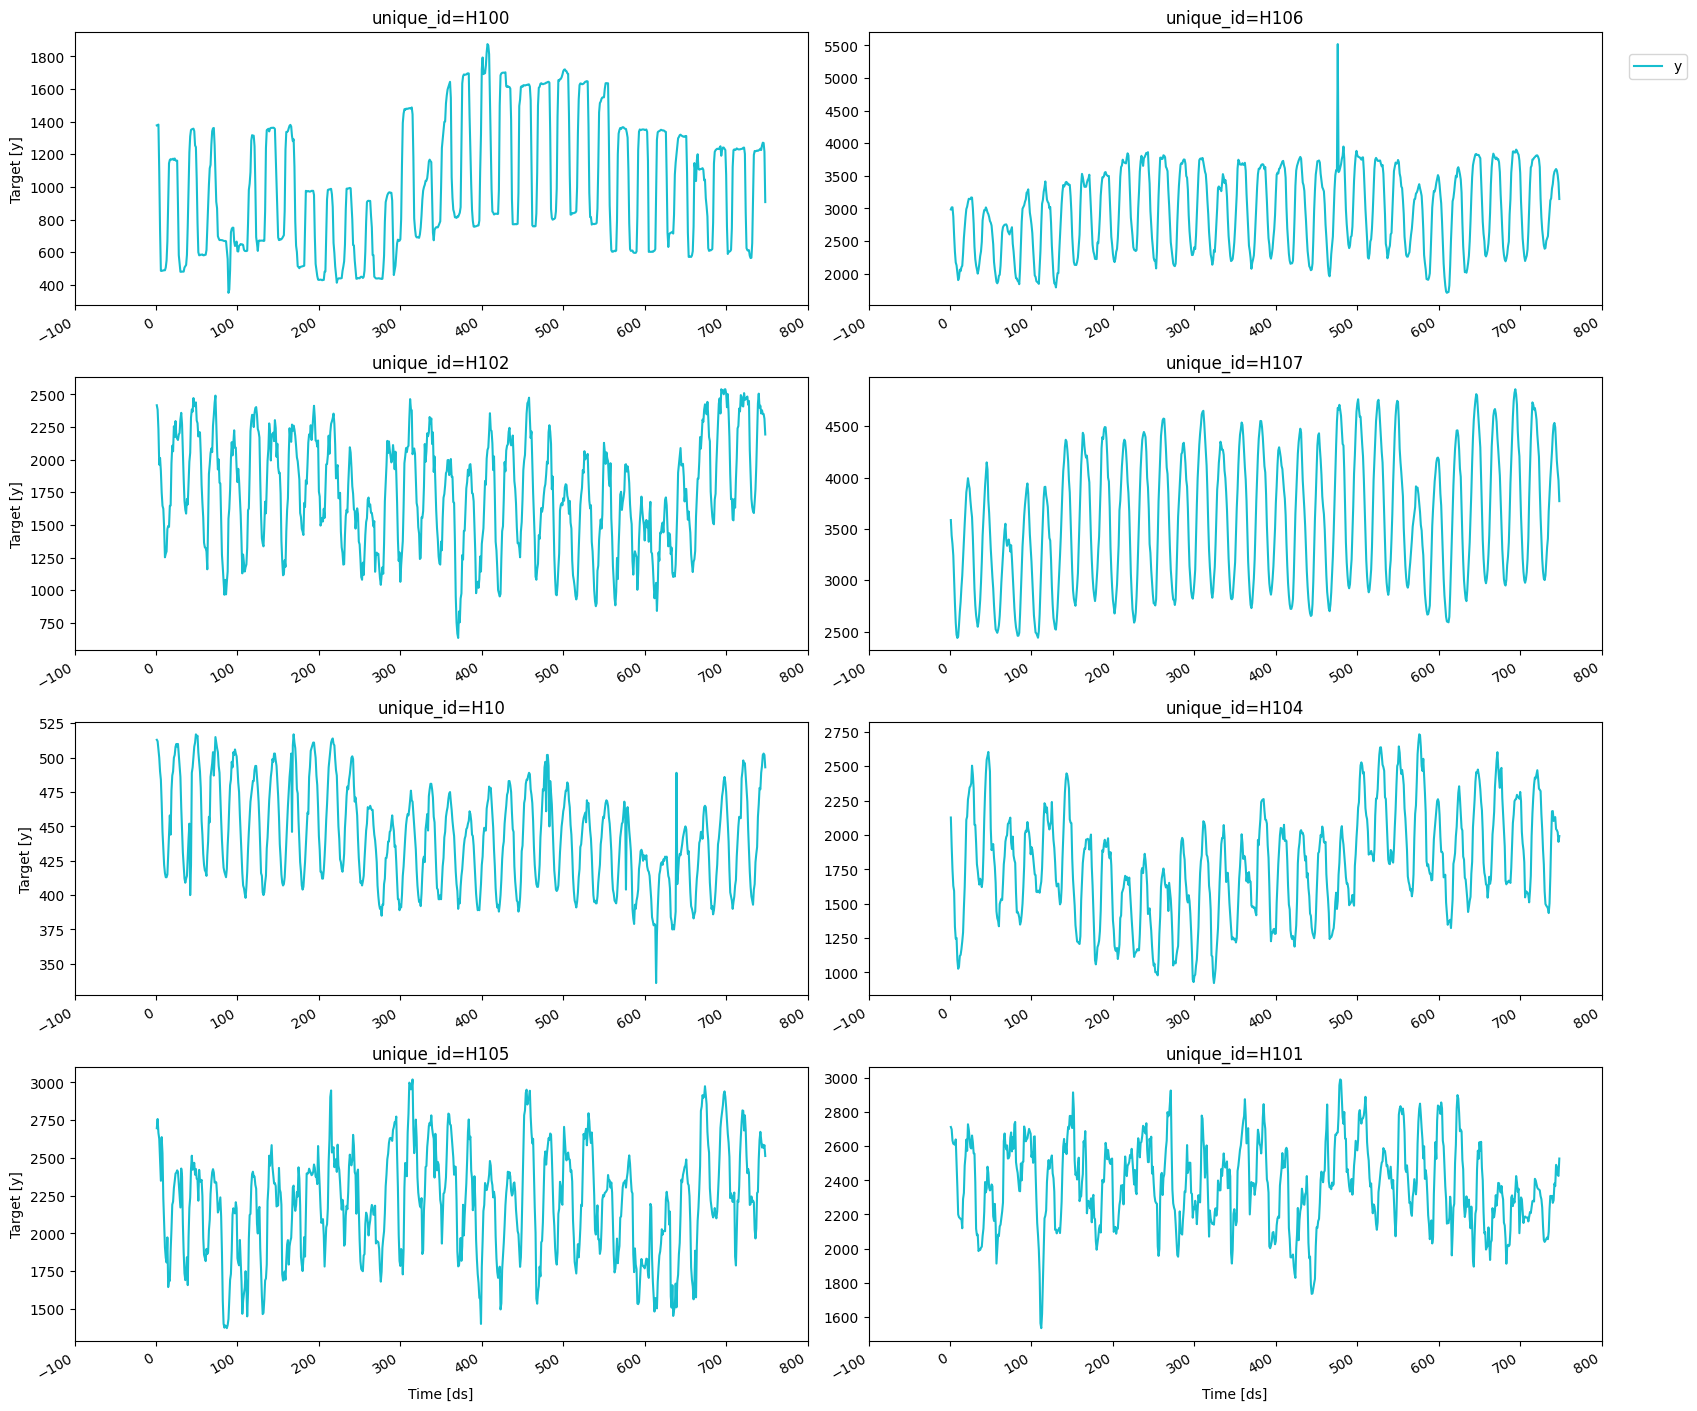

In [5]:
plot_series(Y_df, engine = "matplotlib")

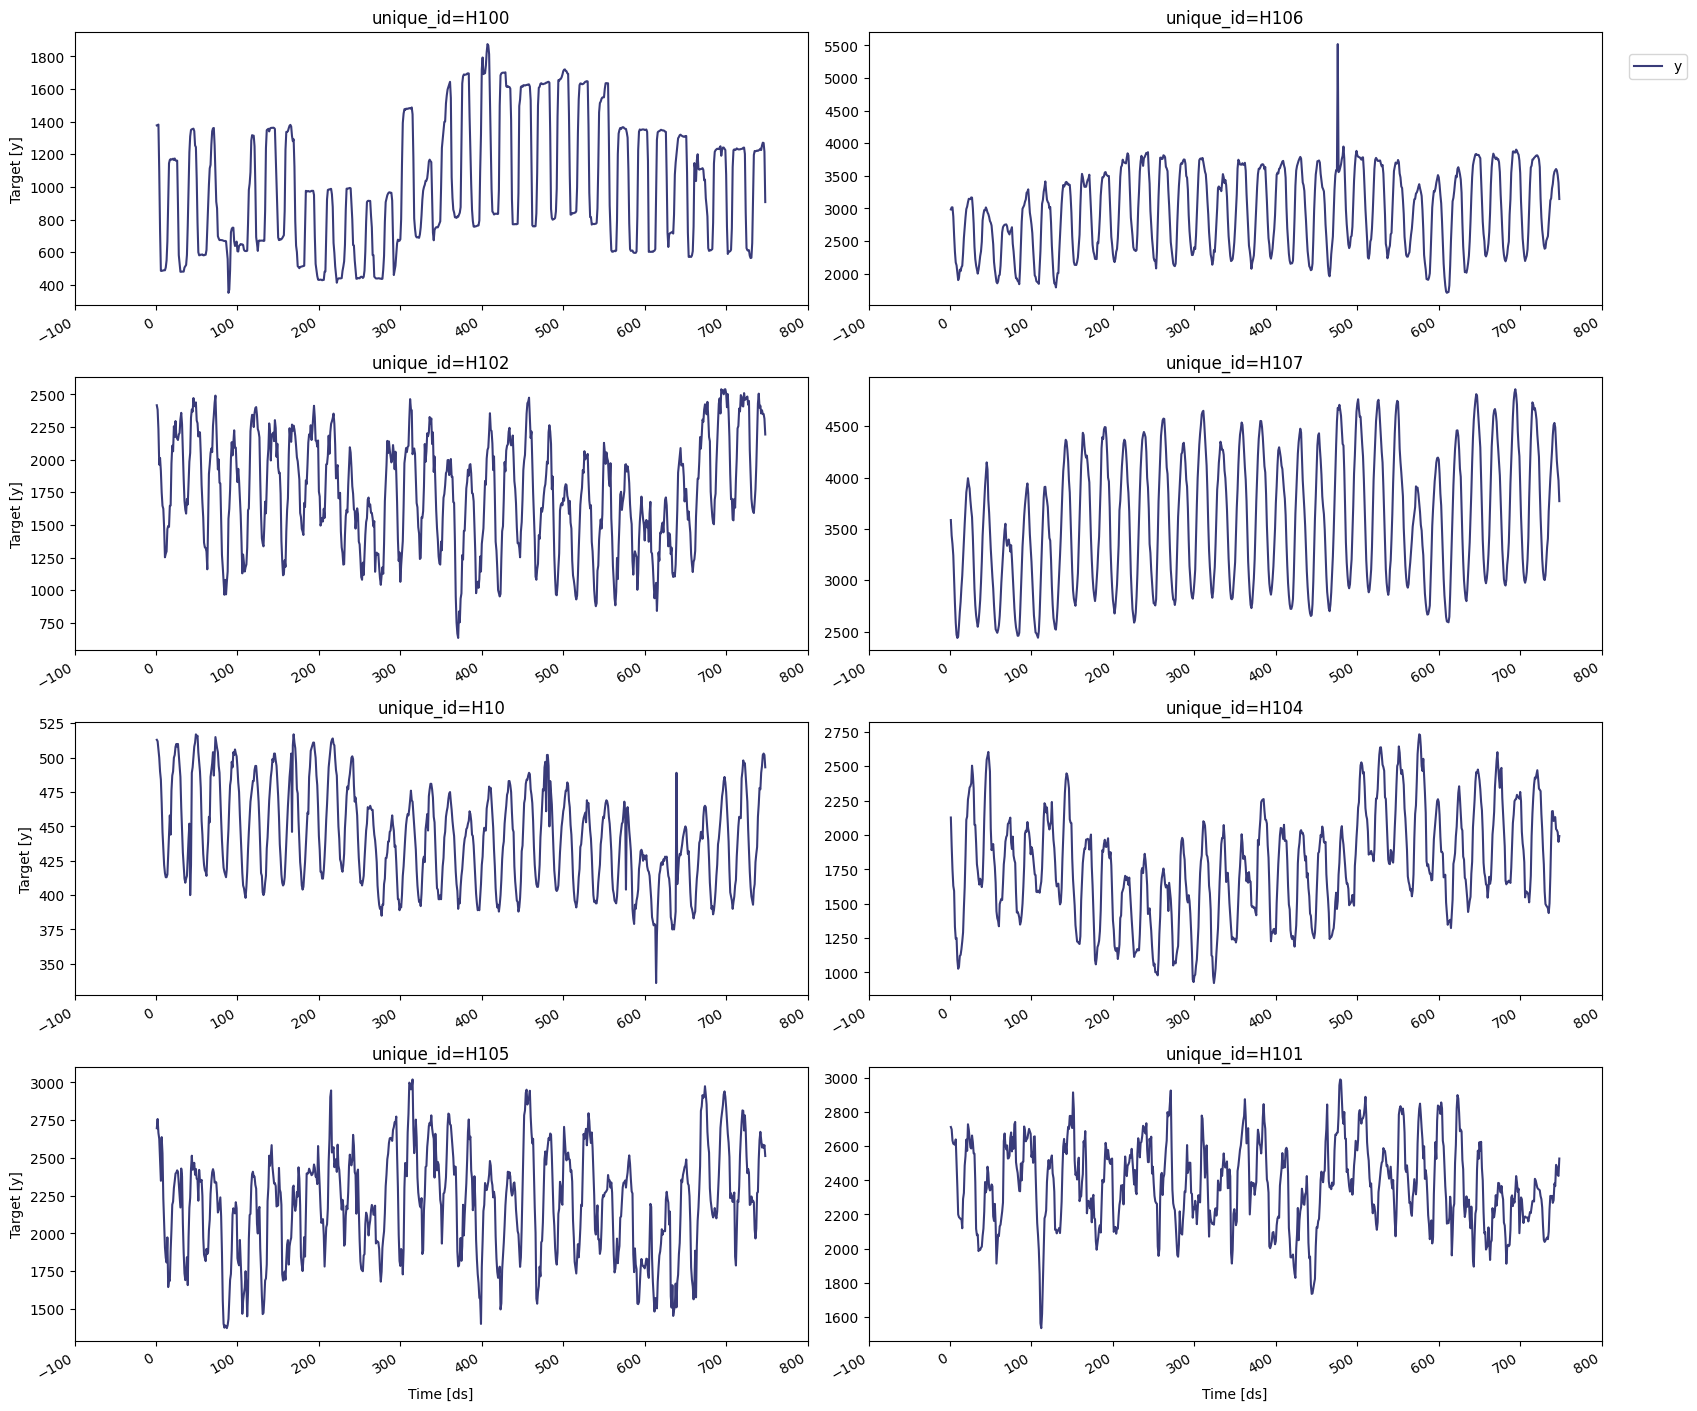

In [43]:
StatsForecast.plot(Y_df, engine = "matplotlib")

# model

In [7]:
config_nhits = {
    "input_size": tune.choice([48, 48*2, 48*3]),                                # Length of input window
    "start_padding_enabled": True,
    "n_blocks": 5*[1],                                                          # Length of input window
    "mlp_units": 5 * [[64, 64]],                                                # Length of input window
    "n_pool_kernel_size": tune.choice([5*[1], 5*[2], 5*[4], [8, 4, 2, 1, 1]]),  # MaxPooling Kernel size
    "n_freq_downsample": tune.choice([[8, 4, 2, 1, 1], [1, 1, 1, 1, 1]]),       # Interpolation expressivity ratios
    "learning_rate": tune.loguniform(1e-4, 1e-2),            # Initial Learning rate
    "scaler_type": tune.choice([None]),                      # Scaler type
    "max_steps": tune.choice([1000]),                        # Max number of training iterations
    "batch_size": tune.choice([1, 4, 10]),                   # Number of series in batch
    "windows_batch_size": tune.choice([128, 256, 512]),      # Number of windows in batch
    "random_seed": tune.randint(1, 20),                      # Random seed
}

config_lstm = {
    "input_size": tune.choice([48, 48*2, 48*3]),    # Length of input window
    "encoder_hidden_size": tune.choice([64, 128]),  # Hidden size of LSTM cells
    "encoder_n_layers": tune.choice([2, 4]),        # Number of layers in LSTM
    "learning_rate": tune.loguniform(1e-4, 1e-2),   # Initial Learning rate
    "scaler_type": tune.choice(['robust']),         # Scaler type
    "max_steps": tune.choice([500, 1000]),          # Max number of training iterations
    "batch_size": tune.choice([1, 4]),              # Number of series in batch
    "random_seed": tune.randint(1, 20),             # Random seed
}

nf = NeuralForecast(
    models = [
        AutoNHITS(
            h = 48,
            config = config_nhits,
            loss = MQLoss(),
            num_samples = 5,
        ),
        AutoLSTM(
            h = 48,
            config = config_lstm,
            loss = MQLoss(),
            num_samples = 2,
        )
    ],
    freq = 1,
)
nf.fit(df = Y_df)

2024-12-06 14:38:19,700	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_c3b7b_00000
Traceback (most recent call last):
  File "/Users/wangzf/Applications/miniconda3/envs/ts/lib/python3.11/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/Users/wangzf/Applications/miniconda3/envs/ts/lib/python3.11/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/Users/wangzf/Applications/miniconda3/envs/ts/lib/python3.11/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/wangzf/Applications/miniconda3/envs/ts/lib/python3.11/site-packages/ray/_private/worker.py", line 2661, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                  

RuntimeError: No best trial found for the given metric: loss. This means that no trial has reported this metric, or all values reported for this metric are NaN. To not ignore NaN values, you can set the `filter_nan_and_inf` arg to False.

# model predicting

In [36]:
fcst_df = nf.predict()
fcst_df.columns = fcst_df.columns.str.replace("-median", "")
fcst_df

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

,ds,AutoNHITS,AutoNHITS-lo-90,AutoNHITS-lo-80,AutoNHITS-hi-80,AutoNHITS-hi-90,AutoLSTM,AutoLSTM-lo-90,AutoLSTM-lo-80,AutoLSTM-hi-80,AutoLSTM-hi-90
unique_id,,,,,,,,,,,
H1,749,608.242188,481.981812,529.412231,649.917358,661.481689,597.335327,541.744995,565.305054,641.205505,651.853760
H1,750,540.053894,364.136475,438.327606,594.542847,638.000244,533.153442,480.685303,505.748718,572.563599,592.649780
H1,751,490.817200,270.814514,352.022339,542.855591,580.746277,480.127930,426.621521,451.443176,522.569824,545.443909
H1,752,444.545441,211.686447,283.296417,497.985321,531.791565,448.565674,392.283813,414.859802,490.888184,510.657257
H1,753,408.553711,189.323425,260.419556,486.748505,513.536499,436.056396,385.510559,408.974121,475.269165,486.741211
...,...,...,...,...,...,...,...,...,...,...,...
H107,792,4424.589355,3737.593506,3850.625488,5105.720703,5245.225098,4391.256836,3931.158936,4039.108643,4681.344727,4778.907715
H107,793,4325.877930,3647.203857,3741.950195,4972.188965,5200.801270,4285.604004,3865.210205,3957.655762,4574.051758,4662.636719
H107,794,4197.992188,3494.439941,3686.592041,4777.175781,4985.701660,4100.871582,3706.672363,3791.406494,4397.928711,4507.791992


# result

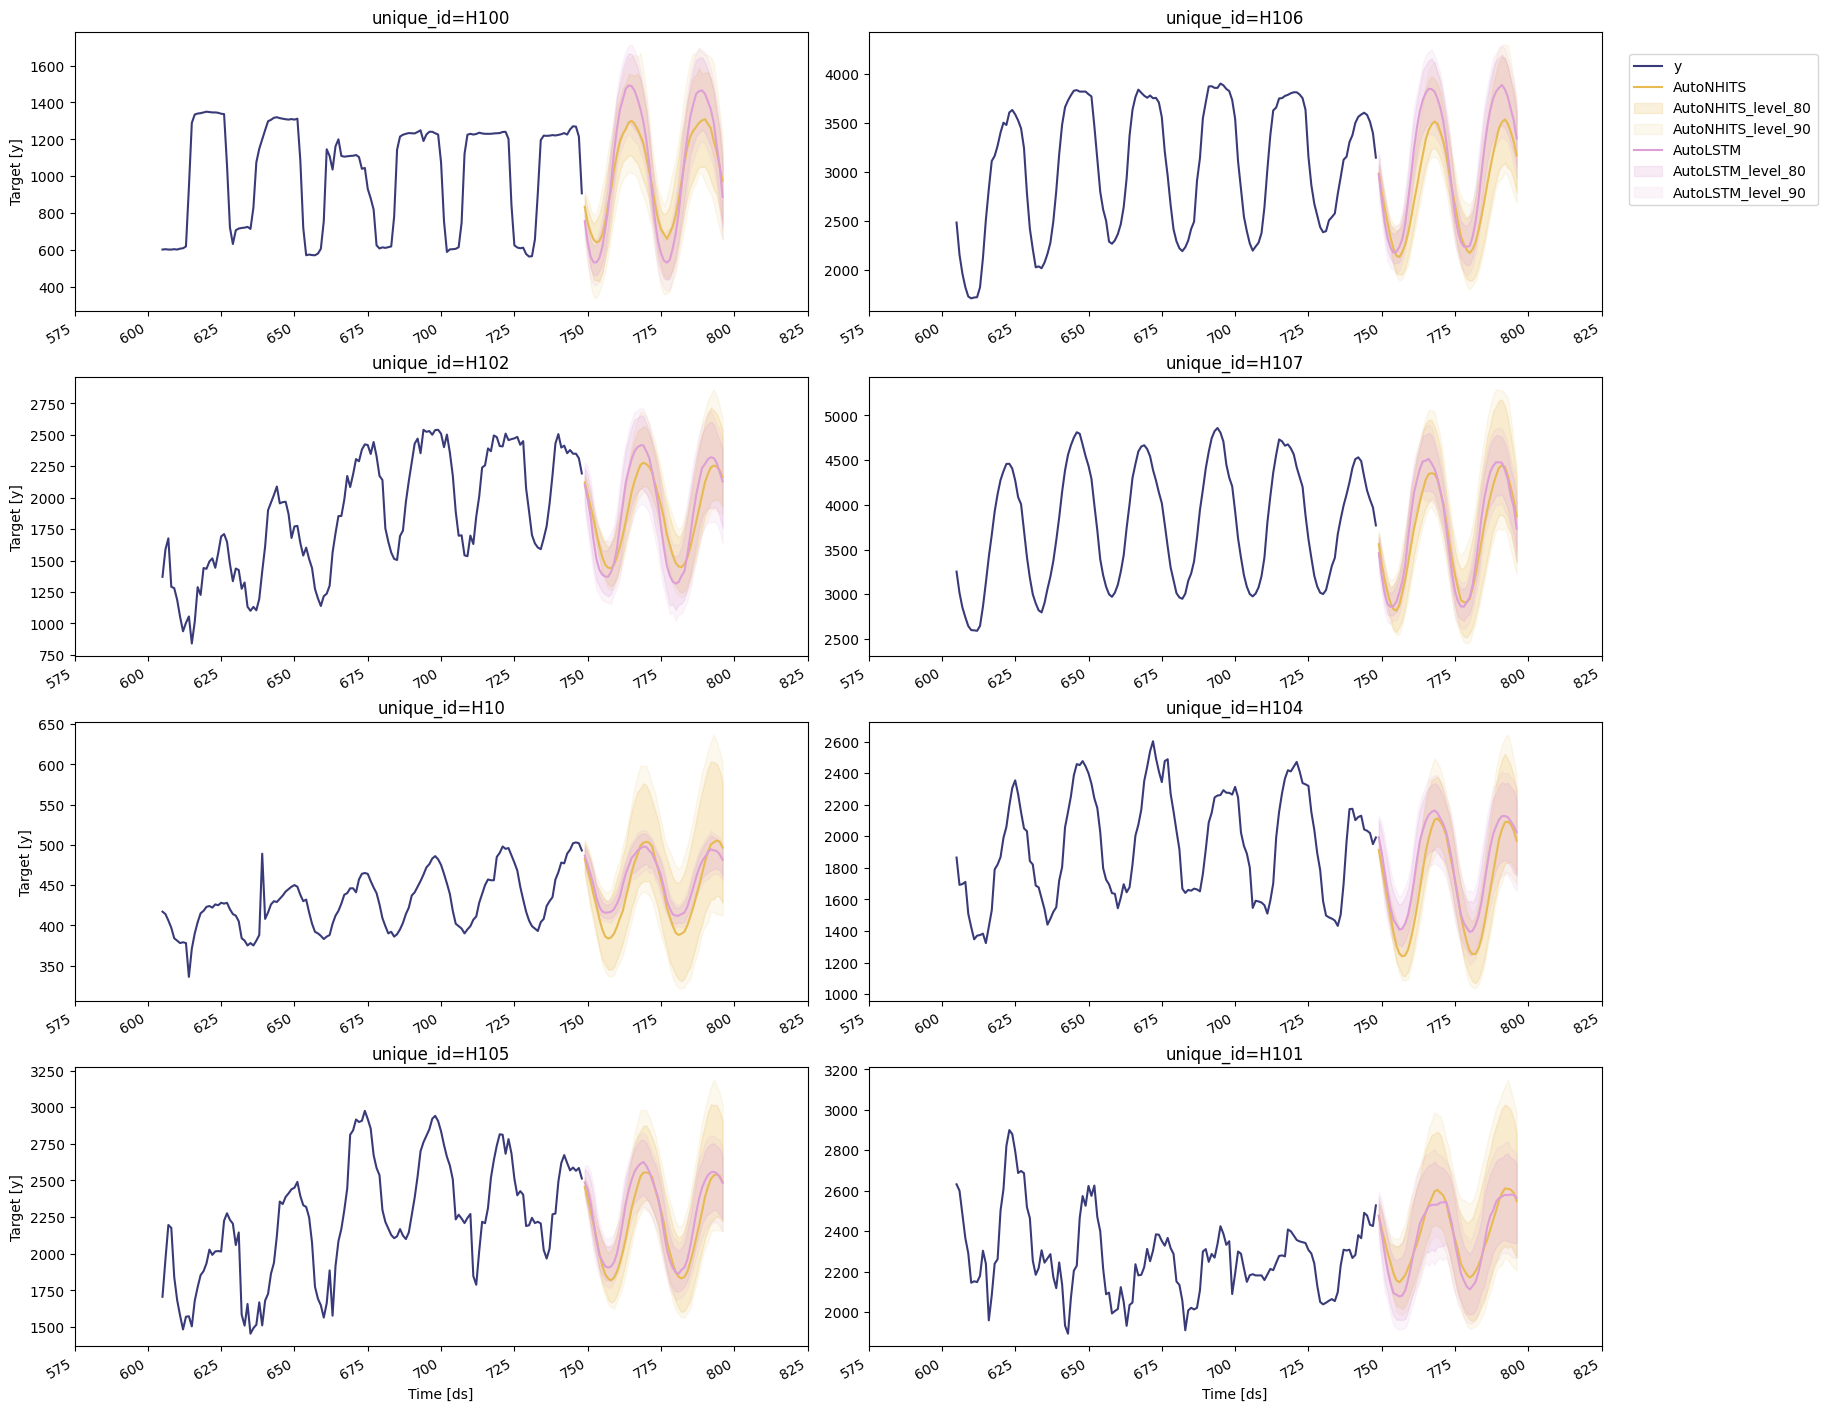

In [38]:
StatsForecast.plot(Y_df, fcst_df, engine='matplotlib', max_insample_length=48 * 3, level=[80, 90])

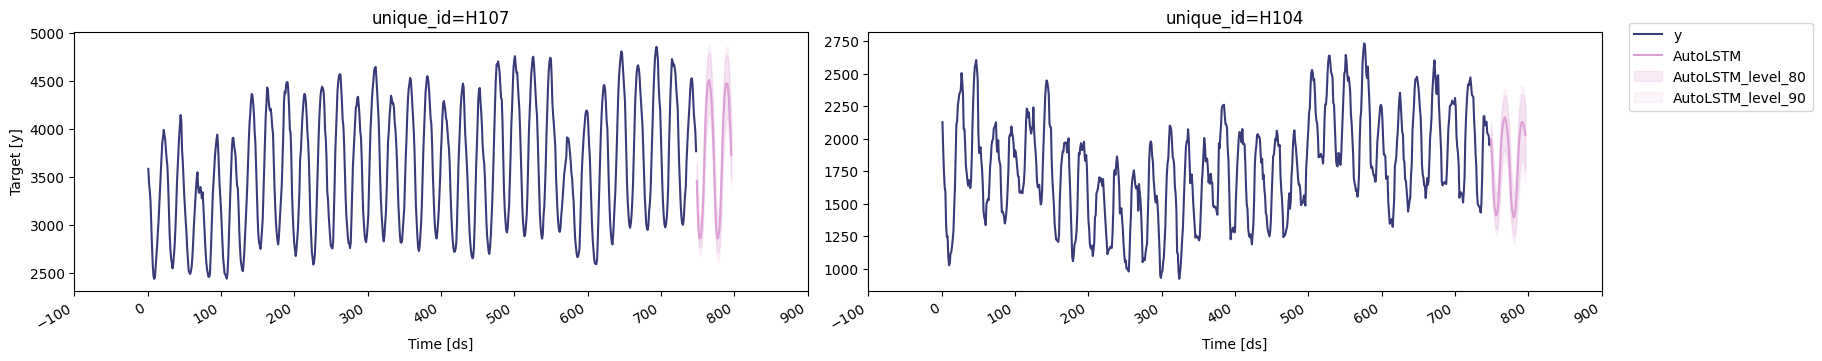

In [39]:
# Plot to unique_ids and some selected models
StatsForecast.plot(Y_df, fcst_df, models=["AutoLSTM"], unique_ids=["H107", "H104"], level=[80, 90], engine='matplotlib')

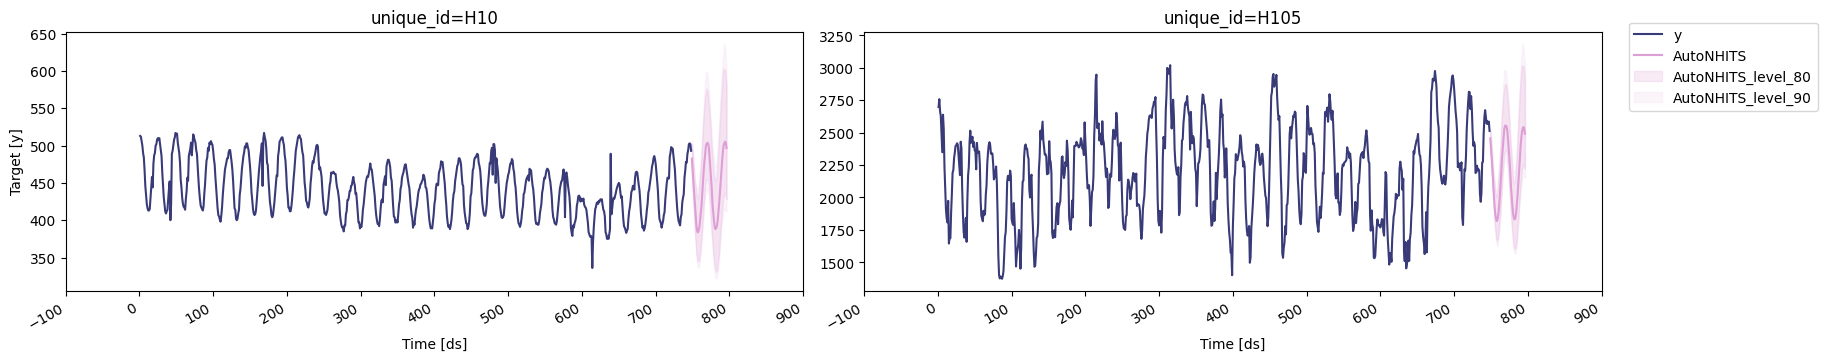

In [44]:
# Explore other models 
StatsForecast.plot(Y_df, fcst_df, models=["AutoNHITS"], unique_ids=["H10", "H105"], level=[80, 90], engine='matplotlib')